<a href="https://colab.research.google.com/github/NguyenPhanNhatLan/medical_re/blob/main/vihealth_rbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
print(torch.cuda.is_available()) # Phải trả về True

True


In [ ]:
!git clone https://github.com/NguyenPhanNhatLan/medical_re.git

Cloning into 'medical_re'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 115 (delta 49), reused 87 (delta 28), pack-reused 0 (from 0)
Receiving objects: 100% (115/115), 4.17 MiB | 3.82 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [ ]:
%cd medical_re

/content/medical_re/medical_re


In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from encoder.vihealth_encoder import ViHealthBERTEncoder
from datasets.rbert_dataset import RBERTDataset
from models.r_bert import RBERT
import config as cfg
import json
import torch.nn as nn
import random
import numpy as np
from typing import Dict, List

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)

In [ ]:
TRAIN_PATH ="./data/train.json"
DEV_PATH ="./data/dev.json"
TEST_PATH ="./data/test.json"

In [ ]:
encoder = ViHealthBERTEncoder()
tokenizer = encoder.tokenizer

In [ ]:
with open(TRAIN_PATH, "r", encoding="utf-8") as f:
    train_data = json.load(f)

labels = sorted({ex["relation"] for ex in train_data})
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}

print("num labels:", len(label2id))
print("example:", list(label2id.items())[:10])

num labels: 5
example: [('CAUSE_DISEASE', 0), ('DIAGNOSTIC_DISEASE', 1), ('DISEASE_SYMPTOM', 2), ('DISEASE_TREATMENT', 3), ('NO_RELATION', 4)]


In [ ]:
train_ds = RBERTDataset(
    json_path=TRAIN_PATH,
    encoder=encoder,
    label2id=label2id,
    max_length=cfg.MODEL_MAX_LEN,
)


In [ ]:

def rbert_collate_fn(batch: List[Dict], pad_token_id: int) -> Dict[str, torch.Tensor]:
    """
    Collate function for R-BERT dataset.
    Pads input_ids/attention_mask/e1_mask/e2_mask to max length in batch.

    Expected keys per sample:
      - input_ids: Tensor [L]
      - attention_mask: Tensor [L]
      - e1_mask: Tensor [L] (0/1)
      - e2_mask: Tensor [L] (0/1)
      - label_id: int
    """
    input_ids = [x["input_ids"] for x in batch]
    attention_mask = [x["attention_mask"] for x in batch]
    e1_mask = [x["e1_mask"] for x in batch]
    e2_mask = [x["e2_mask"] for x in batch]
    labels = torch.tensor([x["label_id"] for x in batch], dtype=torch.long)

    # pad to [B, Lmax]
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=pad_token_id)
    attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)

    # entity masks should be padded with 0 (meaning "not in entity span")
    e1_mask = pad_sequence(e1_mask, batch_first=True, padding_value=0)
    e2_mask = pad_sequence(e2_mask, batch_first=True, padding_value=0)

    # Ensure dtype is compatible with pooling (long/float both ok; float is safer)
    e1_mask = e1_mask.to(torch.float32)
    e2_mask = e2_mask.to(torch.float32)

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "e1_mask": e1_mask,
        "e2_mask": e2_mask,
        "label_id": labels,
    }


In [ ]:
pad_id = encoder.tokenizer.pad_token_id
if pad_id is None:
    # một số tokenizer không có pad_token -> fallback
    pad_id = 0

train_loader = DataLoader(
    train_ds,
    batch_size=cfg.BATCH_SIZE,
    shuffle=True,
    collate_fn=lambda b: rbert_collate_fn(b, pad_token_id=pad_id),
)

In [ ]:
dev_ds = RBERTDataset(
    json_path=DEV_PATH,
    encoder=encoder,
    label2id=label2id,
    max_length=cfg.MODEL_MAX_LEN
)

dev_loader = DataLoader(
    dev_ds,
    batch_size=cfg.BATCH_SIZE,
    shuffle=False,
    collate_fn=lambda b: rbert_collate_fn(b, pad_token_id=pad_id)
)

In [ ]:
import copy
import itertools
import torch
from tqdm.auto import tqdm
from transformers import get_linear_schedule_with_warmup

# ===== GRID =====
LR_GRID = [1e-5, 2e-5, 3e-5, 5e-5]
DROPOUT_GRID = [0.1, 0.2]
WARMUP_RATIO_GRID = [0.0, 0.1]

# ===== FIX PARAMS =====
WEIGHT_DECAY = 0.01
GRAD_CLIP_NORM = 1.0

# Search nhanh để khỏi quá lâu
SEARCH_EPOCHS = 1          # 2 hoặc 3
SEARCH_PATIENCE = 1        # early-stop mạnh trong search
SEARCH_MIN_DELTA = 1e-4

USE_AMP = torch.cuda.is_available()
print("USE_AMP:", USE_AMP)


USE_AMP: True


In [ ]:
def build_model(dropout):
    return RBERT(
        encoder=encoder,
        hidden_size=encoder.hidden_size,
        num_labels=len(label2id),
        dropout_rate=dropout
    )


In [ ]:
@torch.no_grad()
def evaluate_loss(model, dataloader, criterion, device):
    model.eval()
    total_loss, n = 0.0, 0

    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        e1_mask = batch["e1_mask"].to(device)
        e2_mask = batch["e2_mask"].to(device)
        labels = batch["label_id"].to(device)

        logits = model(input_ids, attention_mask, e1_mask, e2_mask)
        loss = criterion(logits, labels)

        total_loss += loss.item()
        n += 1

    return total_loss / max(n, 1)


In [ ]:
def train_one_config(lr, dropout, warmup_ratio, train_loader, dev_loader, criterion, device):
    model = build_model(dropout).to(device)

    # Chỉ nên đóng băng nếu bạn muốn tiết kiệm bộ nhớ,
    # nhưng thường Fine-tune BERT nên để True để đạt độ chính xác cao nhất
    for p in model.encoder.parameters():
        p.requires_grad = False

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=WEIGHT_DECAY
    )

    total_steps = len(train_loader) * SEARCH_EPOCHS
    warmup_steps = int(total_steps * warmup_ratio)

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    # Sửa lỗi khởi tạo Scaler (Dùng cú pháp mới nhất)
    scaler = torch.amp.GradScaler('cuda', enabled=USE_AMP)

    best_val = float("inf")
    best_state = None
    patience = 0

    for epoch in range(1, SEARCH_EPOCHS + 1):
        model.train()
        train_bar = tqdm(
            train_loader,
            # leave=False để tránh tràn màn hình khi chạy Grid Search
            desc=f"train e{epoch} (lr={lr:.1e}, dr={dropout})",
            dynamic_ncols=True
        )

        for batch in train_bar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            e1_mask = batch["e1_mask"].to(device)
            e2_mask = batch["e2_mask"].to(device)
            labels = batch["label_id"].to(device)

            optimizer.zero_grad(set_to_none=True)

            # Sửa lỗi Autocast: Sử dụng đồng nhất một kiểu
            with torch.amp.autocast('cuda', enabled=USE_AMP):
                logits = model(input_ids, attention_mask, e1_mask, e2_mask)
                loss = criterion(logits, labels)

            scaler.scale(loss).backward()

            # Unscale trước khi clip gradient
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)

            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            # Hiển thị progress
            train_bar.set_postfix(loss=f"{loss.item():.4f}")

        # Đánh giá sau mỗi epoch
        val_loss = evaluate_loss(model, dev_loader, criterion, device)
        print(f"Epoch {epoch} - Val Loss: {val_loss:.4f}")

        if (best_val - val_loss) > SEARCH_MIN_DELTA:
            best_val = val_loss
            # Lưu state_dict vào CPU để tránh tràn VRAM GPU
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            patience = 0
        else:
            patience += 1
            if patience >= SEARCH_PATIENCE:
                print("Early stopping triggered!")
                break

    return best_val, best_state

In [ ]:
criterion = nn.CrossEntropyLoss()


# Best Config - Grid Search (test random 6 samples)

Sử dụng Val Loss làm tiêu chí chính để tìm ra vùng tham số giúp mô hình ổn định nhất.

In [ ]:
combos = list(itertools.product(LR_GRID, DROPOUT_GRID, WARMUP_RATIO_GRID))
combos = random.sample(combos, k=6)
best = {"val_loss": float("inf"), "cfg": None, "state": None}
results = []

grid_bar = tqdm(combos, desc="GRID", total=len(combos))

for lr, dr, wr in grid_bar:
    grid_bar.set_postfix(lr=f"{lr:.1e}", dr=dr, wr=wr)

    val_loss, state = train_one_config(
        lr=lr,
        dropout=dr,
        warmup_ratio=wr,
        train_loader=train_loader,
        dev_loader=dev_loader,
        criterion=criterion,
        device=device
    )

    results.append({"lr": lr, "dropout": dr, "warmup_ratio": wr, "val_loss": val_loss})
    tqdm.write(f"[DONE] lr={lr:.1e}, dr={dr}, wr={wr} => best_val={val_loss:.4f}")

    if val_loss < best["val_loss"]:
        best["val_loss"] = val_loss
        best["cfg"] = {"lr": lr, "dropout": dr, "warmup_ratio": wr}
        best["state"] = copy.deepcopy(state)

print("\nBEST CONFIG:", best["cfg"], "best_val_loss=", best["val_loss"])


GRID:   0%|          | 0/6 [00:00<?, ?it/s]

train e1 (lr=2.0e-05, dr=0.1):   0%|          | 0/1950 [00:00<?, ?it/s]

Epoch 1 - Val Loss: 0.9584
[DONE] lr=2.0e-05, dr=0.1, wr=0.0 => best_val=0.9584


train e1 (lr=3.0e-05, dr=0.2):   0%|          | 0/1950 [00:00<?, ?it/s]

Epoch 1 - Val Loss: 0.9204
[DONE] lr=3.0e-05, dr=0.2, wr=0.1 => best_val=0.9204


train e1 (lr=1.0e-05, dr=0.1):   0%|          | 0/1950 [00:00<?, ?it/s]

Epoch 1 - Val Loss: 0.9906
[DONE] lr=1.0e-05, dr=0.1, wr=0.1 => best_val=0.9906


train e1 (lr=3.0e-05, dr=0.2):   0%|          | 0/1950 [00:00<?, ?it/s]

Epoch 1 - Val Loss: 0.9196
[DONE] lr=3.0e-05, dr=0.2, wr=0.0 => best_val=0.9196


train e1 (lr=5.0e-05, dr=0.2):   0%|          | 0/1950 [00:00<?, ?it/s]

Epoch 1 - Val Loss: 0.8807
[DONE] lr=5.0e-05, dr=0.2, wr=0.0 => best_val=0.8807


train e1 (lr=3.0e-05, dr=0.1):   0%|          | 0/1950 [00:00<?, ?it/s]

Epoch 1 - Val Loss: 0.9230
[DONE] lr=3.0e-05, dr=0.1, wr=0.0 => best_val=0.9230

BEST CONFIG: {'lr': 5e-05, 'dropout': 0.2, 'warmup_ratio': 0.0} best_val_loss= 0.8806897466544246


In [ ]:
import pandas as pd

# Tạo bảng tổng hợp
df_results = pd.DataFrame(results)
# Sắp xếp theo Val Loss tăng dần (thấp nhất lên đầu)
df_results = df_results.sort_values(by="val_loss")

print("\nBảng xếp hạng các cấu hình:")
print(df_results)


Bảng xếp hạng các cấu hình:
        lr  dropout  warmup_ratio  val_loss
4  0.00005      0.2           0.0  0.880690
3  0.00003      0.2           0.0  0.919607
1  0.00003      0.2           0.1  0.920427
5  0.00003      0.1           0.0  0.923006
0  0.00002      0.1           0.0  0.958434
2  0.00001      0.1           0.1  0.990584


# Best Config - Optuna

Sử dụng Val Loss làm tiêu chí chính để tìm ra vùng tham số giúp mô hình ổn định nhất.

In [ ]:
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 33.6 MB/s eta 0:00:00


In [ ]:
def objective(trial):
    # 1. Khai báo không gian tìm kiếm (Search Space)
    # suggest_float cho phép thử các giá trị liên tục, không bị bó buộc như Grid Search
    lr = trial.suggest_float("lr", 1e-5, 5e-5, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.4)
    warmup_ratio = trial.suggest_float("warmup_ratio", 0.0, 0.2)

    # Bạn có thể thử cả các kiến trúc khác nếu muốn
    # weight_decay = trial.suggest_float("weight_decay", 1e-4, 1e-2, log=True)

    # 2. Gọi hàm train (Dùng SEARCH_EPOCHS nhỏ để tìm kiếm nhanh)
    # Lưu ý: train_one_config cần trả về val_loss
    val_loss, _ = train_one_config(
        lr=lr,
        dropout=dropout,
        warmup_ratio=warmup_ratio,
        train_loader=train_loader,
        dev_loader=dev_loader,
        criterion=criterion,
        device=device
    )

    # 3. Giải phóng bộ nhớ sau mỗi Trial để tránh tràn VRAM
    torch.cuda.empty_cache()
    import gc
    gc.collect()

    return val_loss

In [ ]:
# Tạo Study: mục tiêu là minimize (giảm tối đa) Val Loss
study = optuna.create_study(direction="minimize", study_name="vihealthbert_re_tuning")
study.enqueue_trial({
    "lr": 5e-05,
    "dropout": 0.2,
    "warmup_ratio": 0.0
})
# Bắt đầu chạy
study.optimize(objective, n_trials=15)

print("-" * 30)
print("KẾT QUẢ TỐI ƯU NHẤT:")
print(f"  Val Loss thấp nhất: {study.best_value:.4f}")
print(f"  Bộ tham số: {study.best_params}")

[I 2026-01-15 18:12:43,466] A new study created in memory with name: vihealthbert_re_tuning


train e1 (lr=1.8e-05, dr=0.3871914372027657):   0%|          | 0/1950 [00:00<?, ?it/s]

Epoch 1 - Val Loss: 0.2687


[I 2026-01-15 18:15:53,046] Trial 0 finished with value: 0.26865721541288934 and parameters: {'lr': 1.8217001309661613e-05, 'dropout': 0.3871914372027657, 'warmup_ratio': 0.07413420191986811}. Best is trial 0 with value: 0.26865721541288934.


train e1 (lr=1.8e-05, dr=0.21039899492276412):   0%|          | 0/1950 [00:00<?, ?it/s]

Epoch 1 - Val Loss: 0.2677


[I 2026-01-15 18:19:06,122] Trial 1 finished with value: 0.26765876338954586 and parameters: {'lr': 1.8024321563419578e-05, 'dropout': 0.21039899492276412, 'warmup_ratio': 0.11719925140908433}. Best is trial 1 with value: 0.26765876338954586.


train e1 (lr=4.9e-05, dr=0.3969764351583057):   0%|          | 0/1950 [00:00<?, ?it/s]

Epoch 1 - Val Loss: 0.2612


[I 2026-01-15 18:22:07,596] Trial 2 finished with value: 0.26119262779887276 and parameters: {'lr': 4.873126353105032e-05, 'dropout': 0.3969764351583057, 'warmup_ratio': 0.0998095295150162}. Best is trial 2 with value: 0.26119262779887276.


train e1 (lr=2.2e-05, dr=0.1573296059185173):   0%|          | 0/1950 [00:00<?, ?it/s]

Epoch 1 - Val Loss: 0.2653


[I 2026-01-15 18:25:09,179] Trial 3 finished with value: 0.26530418927842353 and parameters: {'lr': 2.225963975052554e-05, 'dropout': 0.1573296059185173, 'warmup_ratio': 0.14249720253725742}. Best is trial 2 with value: 0.26119262779887276.


train e1 (lr=1.1e-05, dr=0.1389250804190996):   0%|          | 0/1950 [00:00<?, ?it/s]

Epoch 1 - Val Loss: 0.2778


[I 2026-01-15 18:28:12,463] Trial 4 finished with value: 0.27784886166117473 and parameters: {'lr': 1.0901223661447137e-05, 'dropout': 0.1389250804190996, 'warmup_ratio': 0.04363323040813097}. Best is trial 2 with value: 0.26119262779887276.


train e1 (lr=1.4e-05, dr=0.3308226668783747):   0%|          | 0/1950 [00:00<?, ?it/s]

Epoch 1 - Val Loss: 0.2696


[I 2026-01-15 18:31:15,399] Trial 5 finished with value: 0.2695700309819496 and parameters: {'lr': 1.3800517404814795e-05, 'dropout': 0.3308226668783747, 'warmup_ratio': 0.1123871017182535}. Best is trial 2 with value: 0.26119262779887276.


train e1 (lr=1.4e-05, dr=0.2507248555066296):   0%|          | 0/1950 [00:00<?, ?it/s]

Epoch 1 - Val Loss: 0.2675


[I 2026-01-15 18:34:17,425] Trial 6 finished with value: 0.2675447697354267 and parameters: {'lr': 1.4225286318961433e-05, 'dropout': 0.2507248555066296, 'warmup_ratio': 0.12372614775322915}. Best is trial 2 with value: 0.26119262779887276.


train e1 (lr=1.6e-05, dr=0.1812254263562793):   0%|          | 0/1950 [00:00<?, ?it/s]

Epoch 1 - Val Loss: 0.2671


[I 2026-01-15 18:37:19,019] Trial 7 finished with value: 0.2671243372816043 and parameters: {'lr': 1.6045819714745337e-05, 'dropout': 0.1812254263562793, 'warmup_ratio': 0.13728192723379337}. Best is trial 2 with value: 0.26119262779887276.


train e1 (lr=2.0e-05, dr=0.15935935150606678):   0%|          | 0/1950 [00:00<?, ?it/s]

Epoch 1 - Val Loss: 0.2634


[I 2026-01-15 18:40:20,710] Trial 8 finished with value: 0.2634430836244929 and parameters: {'lr': 1.9983690102813238e-05, 'dropout': 0.15935935150606678, 'warmup_ratio': 0.13915596260226937}. Best is trial 2 with value: 0.26119262779887276.


train e1 (lr=1.5e-05, dr=0.11729246037901156):   0%|          | 0/1950 [00:00<?, ?it/s]

Epoch 1 - Val Loss: 0.2681


[I 2026-01-15 18:43:22,501] Trial 9 finished with value: 0.2681208191378439 and parameters: {'lr': 1.5000383962845734e-05, 'dropout': 0.11729246037901156, 'warmup_ratio': 0.09962028302503767}. Best is trial 2 with value: 0.26119262779887276.


train e1 (lr=4.7e-05, dr=0.2895651192013021):   0%|          | 0/1950 [00:00<?, ?it/s]

Epoch 1 - Val Loss: 0.2610


[I 2026-01-15 18:46:24,216] Trial 10 finished with value: 0.26099017833466415 and parameters: {'lr': 4.749610665902156e-05, 'dropout': 0.2895651192013021, 'warmup_ratio': 0.19722655817746182}. Best is trial 10 with value: 0.26099017833466415.


train e1 (lr=5.0e-05, dr=0.30044866611173915):   0%|          | 0/1950 [00:00<?, ?it/s]

Epoch 1 - Val Loss: 0.2609


[I 2026-01-15 18:49:26,262] Trial 11 finished with value: 0.26090125673542136 and parameters: {'lr': 4.991449245961268e-05, 'dropout': 0.30044866611173915, 'warmup_ratio': 0.18943876109125313}. Best is trial 11 with value: 0.26090125673542136.


train e1 (lr=4.5e-05, dr=0.2858380250531161):   0%|          | 0/1950 [00:00<?, ?it/s]

Epoch 1 - Val Loss: 0.2608


[I 2026-01-15 18:52:28,032] Trial 12 finished with value: 0.260844473853005 and parameters: {'lr': 4.547389317613732e-05, 'dropout': 0.2858380250531161, 'warmup_ratio': 0.18791876083218592}. Best is trial 12 with value: 0.260844473853005.


train e1 (lr=3.5e-05, dr=0.31653790084599503):   0%|          | 0/1950 [00:00<?, ?it/s]

Epoch 1 - Val Loss: 0.2628


[I 2026-01-15 18:55:29,785] Trial 13 finished with value: 0.2627692011749891 and parameters: {'lr': 3.48253710864006e-05, 'dropout': 0.31653790084599503, 'warmup_ratio': 0.1992017473196508}. Best is trial 12 with value: 0.260844473853005.


train e1 (lr=3.2e-05, dr=0.258801028021187):   0%|          | 0/1950 [00:00<?, ?it/s]

Epoch 1 - Val Loss: 0.2628


[I 2026-01-15 18:58:32,112] Trial 14 finished with value: 0.26276586107436384 and parameters: {'lr': 3.164264343950774e-05, 'dropout': 0.258801028021187, 'warmup_ratio': 0.17198657575289883}. Best is trial 12 with value: 0.260844473853005.


------------------------------
KẾT QUẢ TỐI ƯU NHẤT:
  Val Loss thấp nhất: 0.2608
  Bộ tham số: {'lr': 4.547389317613732e-05, 'dropout': 0.2858380250531161, 'warmup_ratio': 0.18791876083218592}


In [ ]:
import joblib
import os

# Define the base directory
save_dir = "/content/drive/MyDrive/medical_re/"

# Create the directory if it does not exist
os.makedirs(save_dir, exist_ok=True)

# 1. Lưu toàn bộ đối tượng study (có thể load lại để chạy tiếp trial 16, 17...)
joblib.dump(study, os.path.join(save_dir, "optuna_vihealth_rbert.pkl"))

# 2. Lưu bảng kết quả các lần thử ra CSV
df_results = study.trials_dataframe()
df_results.to_csv(os.path.join(save_dir, "optuna_optuna_vihealth_rbert.csv"), index=False)

print("Đã lưu kết quả tại Drive!")

Đã lưu kết quả tại Drive!


# Train on Best Config

Sử dụng Macro F1 để lưu mô hình tốt nhất

In [ ]:
import copy

def train_final_model(lr, dropout, warmup_ratio, epochs, train_loader, dev_loader, criterion, device, select_metric="macro_f1"):
    model = build_model(dropout).to(device)

    for p in model.parameters():
        p.requires_grad = True

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)

    total_steps = len(train_loader) * epochs
    warmup_steps = int(total_steps * warmup_ratio)
    scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    scaler = torch.amp.GradScaler('cuda', enabled=USE_AMP)

    # Khởi tạo điểm số tốt nhất
    best_score = -1.0
    best_model_state = None

    for epoch in range(1, epochs + 1):
        model.train()
        total_train_loss = 0

        train_bar = tqdm(train_loader, desc=f"Final Train Epoch {epoch}/{epochs}", dynamic_ncols=True)
        for batch in train_bar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            e1_mask = batch["e1_mask"].to(device)
            e2_mask = batch["e2_mask"].to(device)
            labels = batch["label_id"].to(device)

            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda', enabled=USE_AMP):
                logits = model(input_ids, attention_mask, e1_mask, e2_mask)
                loss = criterion(logits, labels)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            total_train_loss += loss.item()
            train_bar.set_postfix(loss=f"{loss.item():.4f}")

        # --- ĐÁNH GIÁ ĐỂ LƯU MODEL TỐT NHẤT ---
        model.eval()
        # Gọi hàm đánh giá của bạn (đảm bảo hàm này return về một dict các chỉ số)
        val_results = evaluate_full_metrics(model, dev_loader, device, num_classes=len(label2id))

        # Lấy giá trị metric cần tối ưu (ví dụ: 'macro_f1')
        current_score = val_results.get(select_metric, 0.0)

        avg_train_loss = total_train_loss / len(train_loader)
        print(f"\n[Epoch {epoch}] Train Loss: {avg_train_loss:.4f} | Dev {select_metric}: {current_score:.4f}")

        # So sánh để giữ lại bộ trọng số tốt nhất (F1 càng cao càng tốt)
        if current_score > best_score:
            best_score = current_score
            best_model_state = copy.deepcopy(model.state_dict())
            print(f"--> [LƯU] Tìm thấy model tốt hơn với {select_metric}: {best_score:.4f}")

    # Khôi phục trọng số tốt nhất trước khi trả về
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\n✅ Đã khôi phục trọng số tốt nhất đạt {select_metric}: {best_score:.4f}")

    return model

Đang train lại model với: {'lr': 4.547389317613732e-05, 'dropout': 0.2858380250531161, 'warmup_ratio': 0.18791876083218592}


Final Train Epoch 1/10:   0%|          | 0/1950 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/244 [00:00<?, ?it/s]


--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       192
           1       0.82      0.75      0.78       203
           2       0.94      0.91      0.93       616
           3       0.94      0.98      0.96       242
           4       0.96      0.98      0.97      2646

    accuracy                           0.95      3899
   macro avg       0.92      0.89      0.91      3899
weighted avg       0.95      0.95      0.95      3899



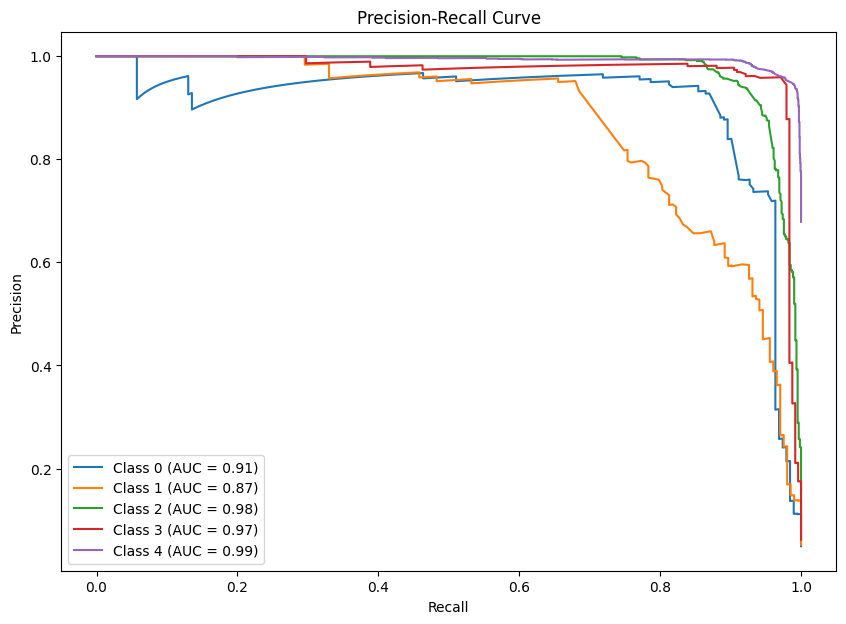


[Epoch 1] Train Loss: 0.2085 | Dev macro_f1: 0.9062
--> [LƯU] Tìm thấy model tốt hơn với macro_f1: 0.9062


Final Train Epoch 2/10:   0%|          | 0/1950 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/244 [00:00<?, ?it/s]


--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       192
           1       0.95      0.70      0.81       203
           2       0.94      0.89      0.92       616
           3       0.98      0.94      0.96       242
           4       0.94      0.98      0.96      2646

    accuracy                           0.94      3899
   macro avg       0.94      0.88      0.91      3899
weighted avg       0.94      0.94      0.94      3899



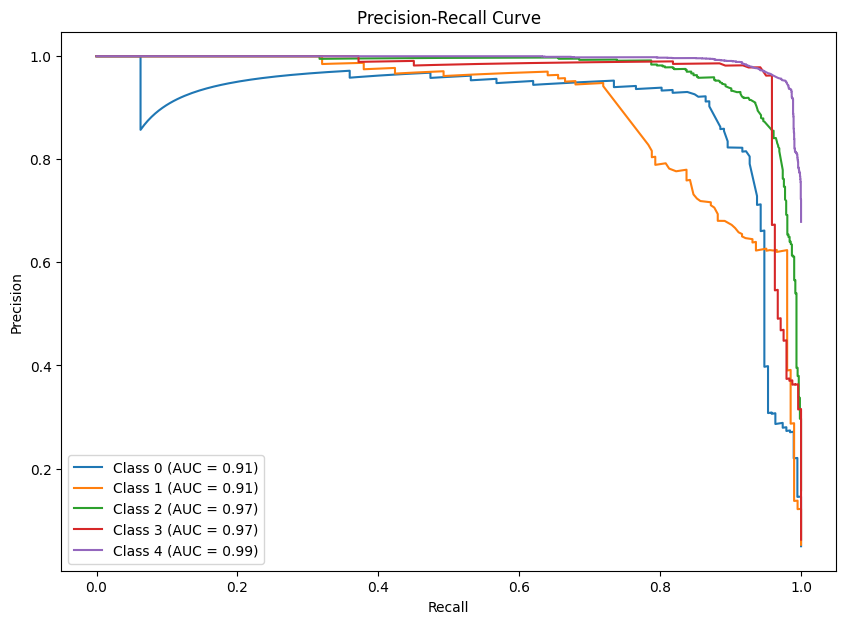


[Epoch 2] Train Loss: 0.1622 | Dev macro_f1: 0.9067
--> [LƯU] Tìm thấy model tốt hơn với macro_f1: 0.9067


Final Train Epoch 3/10:   0%|          | 0/1950 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/244 [00:00<?, ?it/s]


--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       192
           1       0.95      0.69      0.80       203
           2       0.90      0.93      0.92       616
           3       0.98      0.92      0.95       242
           4       0.96      0.98      0.97      2646

    accuracy                           0.95      3899
   macro avg       0.94      0.87      0.90      3899
weighted avg       0.95      0.95      0.95      3899



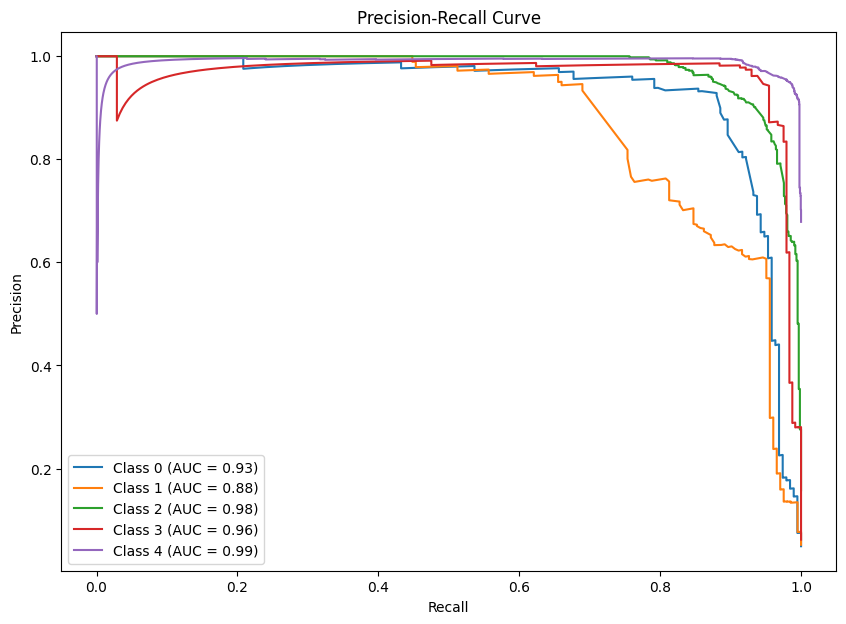


[Epoch 3] Train Loss: 0.1579 | Dev macro_f1: 0.9043


Final Train Epoch 4/10:   0%|          | 0/1950 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/244 [00:00<?, ?it/s]


--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       192
           1       0.81      0.79      0.80       203
           2       0.93      0.94      0.93       616
           3       0.97      0.92      0.94       242
           4       0.97      0.97      0.97      2646

    accuracy                           0.95      3899
   macro avg       0.91      0.90      0.91      3899
weighted avg       0.95      0.95      0.95      3899



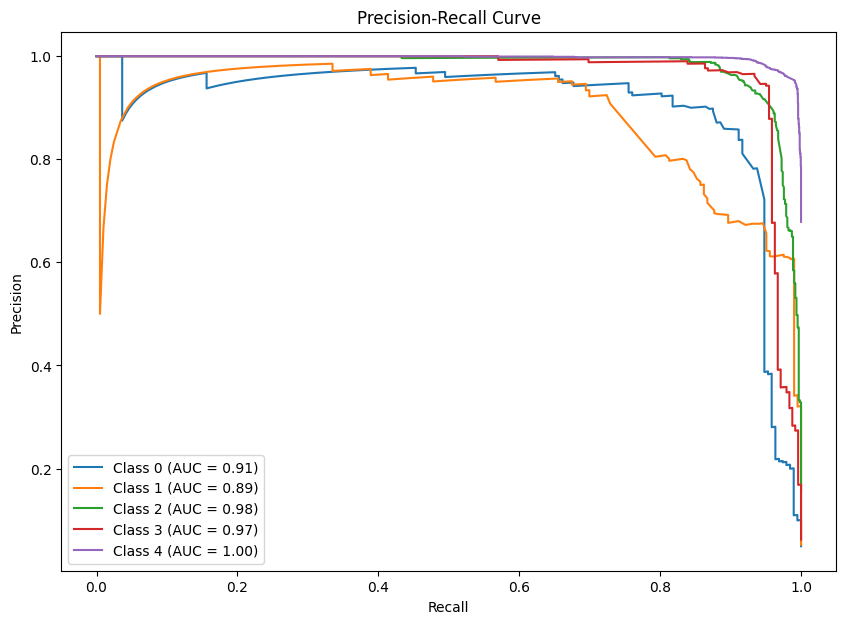


[Epoch 4] Train Loss: 0.1315 | Dev macro_f1: 0.9062


Final Train Epoch 5/10:   0%|          | 0/1950 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/244 [00:00<?, ?it/s]


--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.93      0.88      0.91       192
           1       0.93      0.73      0.82       203
           2       0.93      0.94      0.94       616
           3       0.97      0.95      0.96       242
           4       0.96      0.98      0.97      2646

    accuracy                           0.95      3899
   macro avg       0.94      0.90      0.92      3899
weighted avg       0.95      0.95      0.95      3899



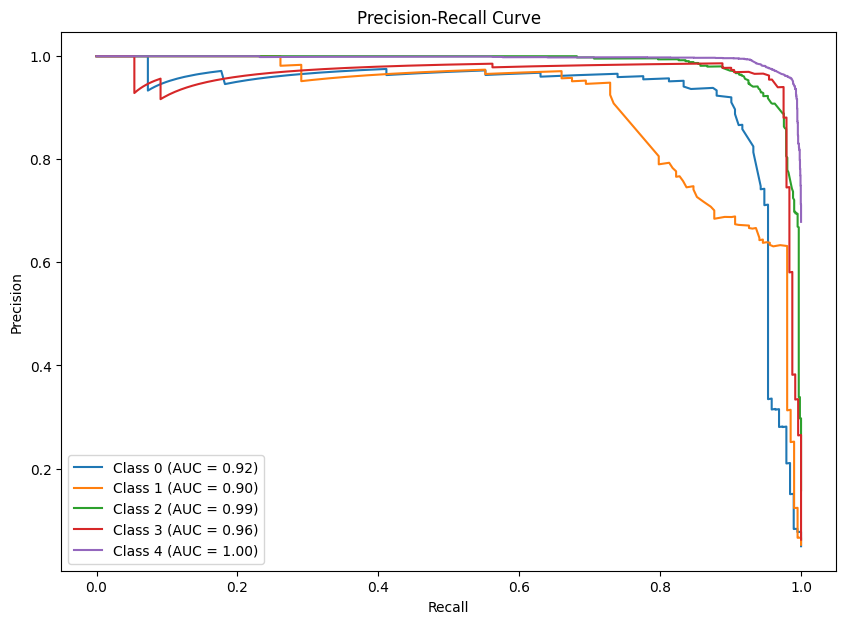


[Epoch 5] Train Loss: 0.1056 | Dev macro_f1: 0.9170
--> [LƯU] Tìm thấy model tốt hơn với macro_f1: 0.9170


Final Train Epoch 6/10:   0%|          | 0/1950 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/244 [00:00<?, ?it/s]


--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       192
           1       0.93      0.70      0.80       203
           2       0.92      0.94      0.93       616
           3       0.97      0.95      0.96       242
           4       0.96      0.98      0.97      2646

    accuracy                           0.95      3899
   macro avg       0.95      0.88      0.91      3899
weighted avg       0.95      0.95      0.95      3899



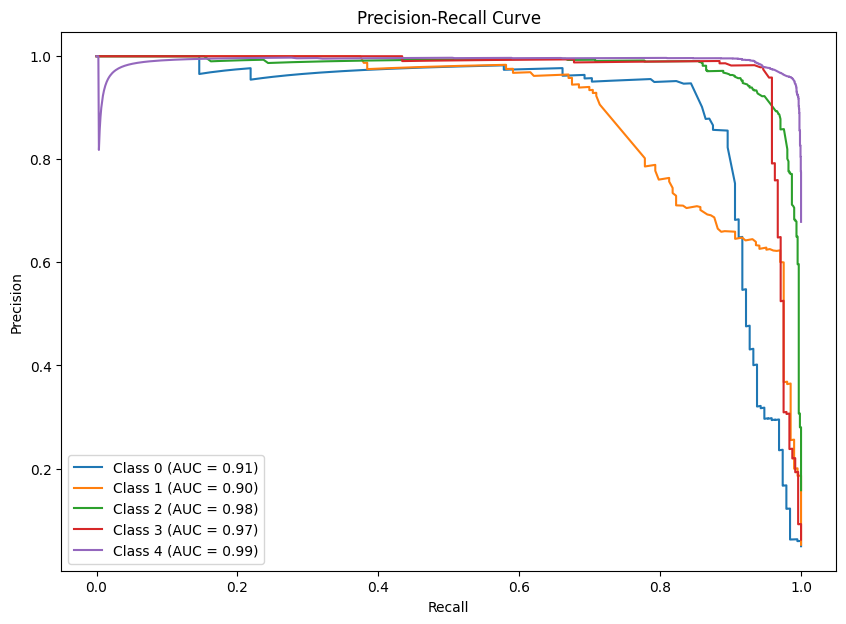


[Epoch 6] Train Loss: 0.1004 | Dev macro_f1: 0.9118


Final Train Epoch 7/10:   0%|          | 0/1950 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/244 [00:00<?, ?it/s]


--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.95      0.90      0.93       192
           1       0.94      0.74      0.83       203
           2       0.94      0.94      0.94       616
           3       0.98      0.96      0.97       242
           4       0.96      0.98      0.97      2646

    accuracy                           0.96      3899
   macro avg       0.95      0.90      0.93      3899
weighted avg       0.96      0.96      0.96      3899



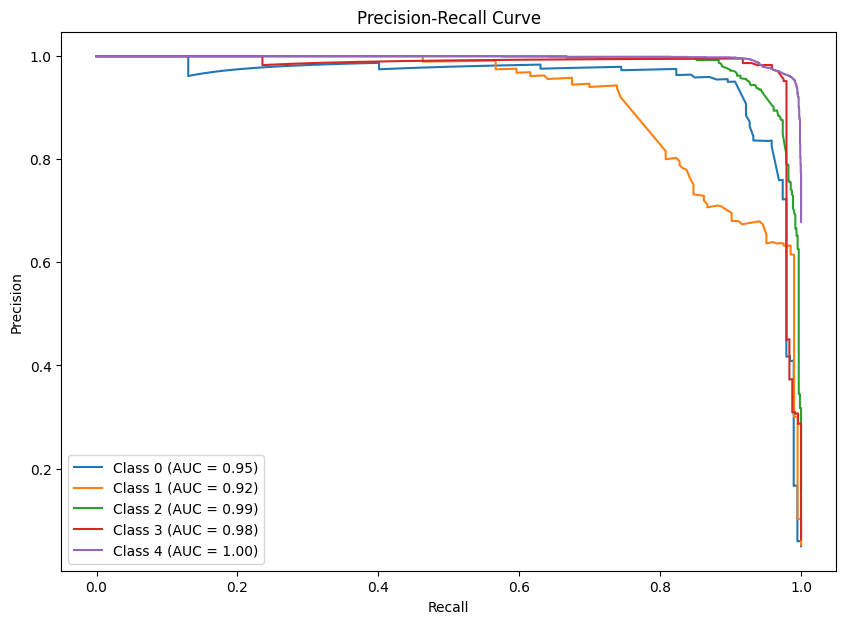


[Epoch 7] Train Loss: 0.0872 | Dev macro_f1: 0.9267
--> [LƯU] Tìm thấy model tốt hơn với macro_f1: 0.9267


Final Train Epoch 8/10:   0%|          | 0/1950 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/244 [00:00<?, ?it/s]


--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       192
           1       0.93      0.73      0.82       203
           2       0.93      0.95      0.94       616
           3       0.98      0.96      0.97       242
           4       0.97      0.98      0.97      2646

    accuracy                           0.96      3899
   macro avg       0.95      0.90      0.93      3899
weighted avg       0.96      0.96      0.96      3899



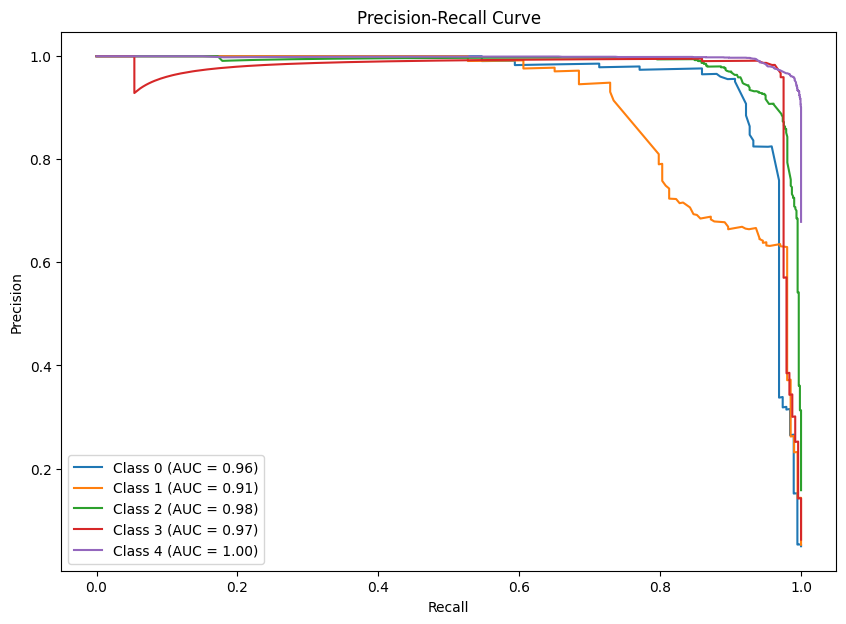


[Epoch 8] Train Loss: 0.0751 | Dev macro_f1: 0.9258


Final Train Epoch 9/10:   0%|          | 0/1950 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/244 [00:00<?, ?it/s]


--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       192
           1       0.95      0.73      0.83       203
           2       0.92      0.95      0.94       616
           3       0.97      0.98      0.97       242
           4       0.97      0.98      0.97      2646

    accuracy                           0.96      3899
   macro avg       0.95      0.91      0.93      3899
weighted avg       0.96      0.96      0.96      3899



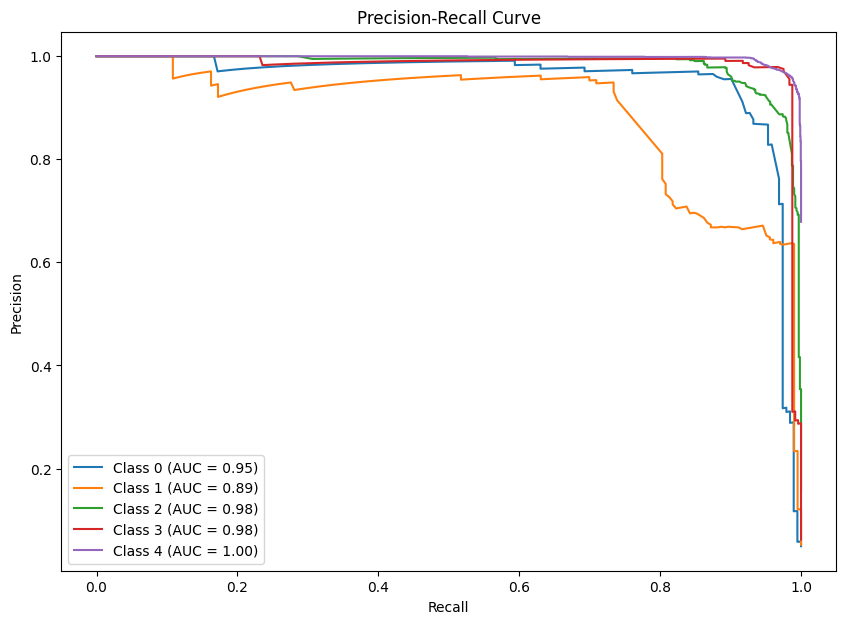


[Epoch 9] Train Loss: 0.0694 | Dev macro_f1: 0.9277
--> [LƯU] Tìm thấy model tốt hơn với macro_f1: 0.9277


Final Train Epoch 10/10:   0%|          | 0/1950 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/244 [00:00<?, ?it/s]


--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       192
           1       0.93      0.73      0.82       203
           2       0.93      0.95      0.94       616
           3       0.97      0.98      0.97       242
           4       0.97      0.98      0.97      2646

    accuracy                           0.96      3899
   macro avg       0.95      0.91      0.93      3899
weighted avg       0.96      0.96      0.96      3899



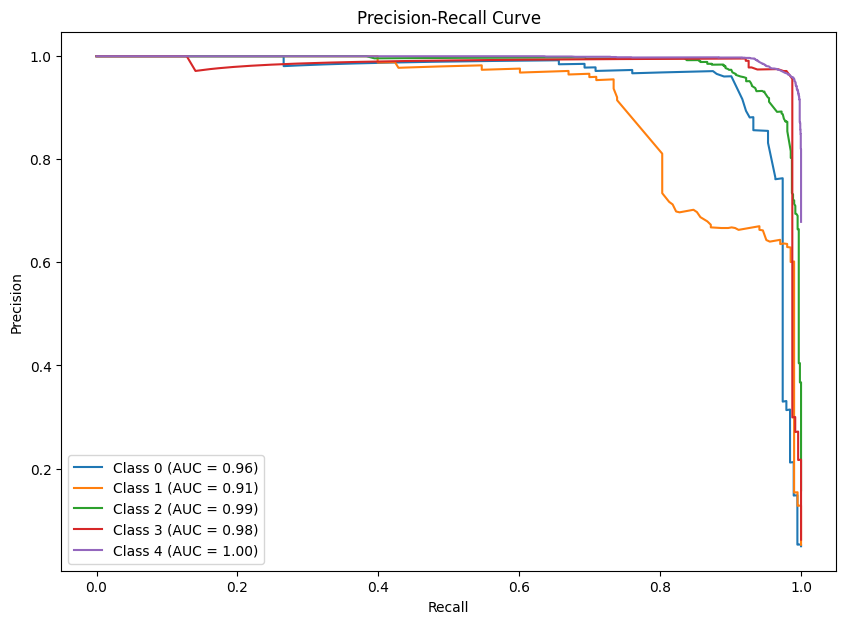


[Epoch 10] Train Loss: 0.0674 | Dev macro_f1: 0.9273

✅ Đã khôi phục trọng số tốt nhất đạt macro_f1: 0.9277


In [ ]:
# Lấy bộ tham số tốt nhất từ Optuna
best_params = study.best_params

print(f"Đang train lại model với: {best_params}")

# Train model cuối cùng (Sử dụng hàm train_final_model đã viết ở trên)
# Lưu ý: Lúc này nên đặt Epochs cao hơn (ví dụ 5-10) và unfreeze BERT

# Gọi hàm và truyền đúng tên metric muốn tối ưu
final_model = train_final_model(
    lr=best_params['lr'],
    dropout=best_params['dropout'],
    warmup_ratio=best_params['warmup_ratio'],
    epochs=10,
    train_loader=train_loader,
    dev_loader=dev_loader,
    criterion=criterion,
    device=device,
    select_metric="macro_f1"  # Đảm bảo dùng đúng biến từ config của bạn
)

# Evaluate on Validation set

In [ ]:
from sklearn.metrics import classification_report, precision_recall_curve, auc, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
@torch.no_grad()
def evaluate_full_metrics(model, dataloader, device, num_classes):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    for batch in tqdm(dataloader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        e1_mask = batch["e1_mask"].to(device)
        e2_mask = batch["e2_mask"].to(device)
        labels = batch["label_id"].to(device)

        with torch.amp.autocast('cuda', enabled=USE_AMP):
            logits = model(input_ids, attention_mask, e1_mask, e2_mask)
            probs = torch.softmax(logits, dim=-1)
            preds = torch.argmax(logits, dim=-1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().detach().numpy()) # Added .detach()
        all_probs.extend(probs.cpu().detach().numpy()) # Added .detach()

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # 1. Macro & Micro F1, Precision, Recall
    print("\n--- CLASSIFICATION REPORT ---")
    print(classification_report(all_labels, all_preds))

    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    micro_f1 = f1_score(all_labels, all_preds, average='micro')

    # 2. Precision-Recall Curve (PRC) và AUC cho từng lớp
    # Trong RE, thường tính AUC-PRC trung bình (Average Precision)
    plt.figure(figsize=(10, 7))
    for i in range(num_classes):
        # Chuyển về bài toán nhị phân cho từng lớp để vẽ PRC
        bin_labels = (all_labels == i).astype(int)
        precision, recall, _ = precision_recall_curve(bin_labels, all_probs[:, i])
        prc_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'Class {i} (AUC = {prc_auc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="best")
    plt.show()

    return {
        "macro_f1": macro_f1,
        "micro_f1": micro_f1,
        "all_probs": all_probs,
        "all_labels": all_labels
    }


ĐÁNH GIÁ TRÊN TẬP DEV (VALIDATION)


Evaluating:   0%|          | 0/244 [00:00<?, ?it/s]


--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       192
           1       0.95      0.73      0.83       203
           2       0.92      0.95      0.94       616
           3       0.97      0.98      0.97       242
           4       0.97      0.98      0.97      2646

    accuracy                           0.96      3899
   macro avg       0.95      0.91      0.93      3899
weighted avg       0.96      0.96      0.96      3899



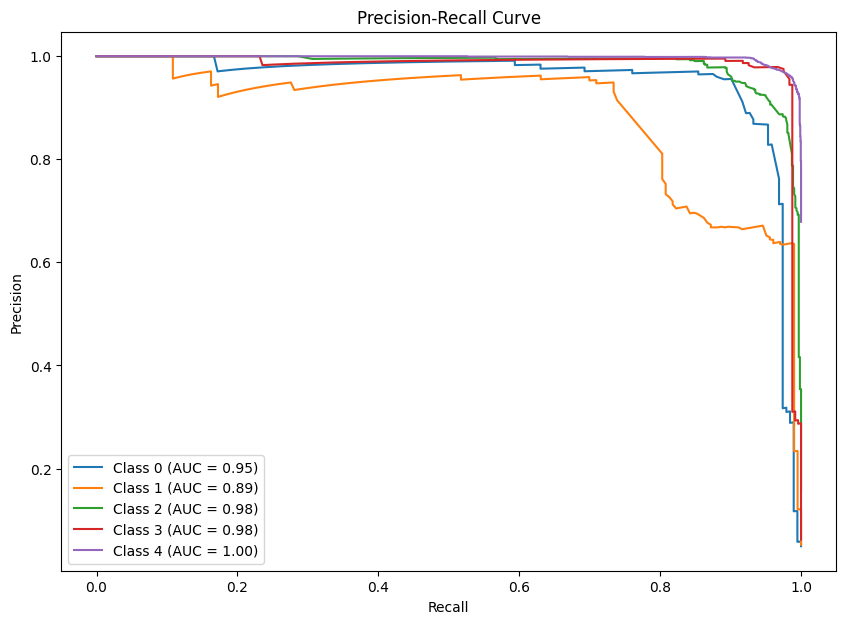

In [ ]:
print("\n" + "="*30)
print("ĐÁNH GIÁ TRÊN TẬP DEV (VALIDATION)")
print("="*30)
dev_results = evaluate_full_metrics(
    model=final_model,
    dataloader=dev_loader,
    device=device,
    num_classes=len(label2id)
)

Evaluate on Test Set

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, f1_score, precision_score,
    recall_score, average_precision_score, precision_recall_curve, auc
)
from sklearn.preprocessing import label_binarize

@torch.no_grad()
def comparison_metrics(model, dataloader, device, num_classes, model_name="Model"):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    for batch in tqdm(dataloader, desc=f"Evaluating {model_name}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        e1_mask = batch["e1_mask"].to(device)
        e2_mask = batch["e2_mask"].to(device)
        labels = batch["label_id"].to(device)

        with torch.amp.autocast('cuda', enabled=USE_AMP):
            logits = model(input_ids, attention_mask, e1_mask, e2_mask)
            probs = torch.softmax(logits, dim=-1)
            preds = torch.argmax(logits, dim=-1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Chuyển nhãn sang dạng binary (one-hot) để tính AUC-PRC và P@K
    y_onehot = label_binarize(all_labels, classes=range(num_classes))

    # --- TÍNH TOÁN CÁC CHỈ SỐ ---

    # 1. Cơ bản: Precision, Recall, F1 (Macro & Micro)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    micro_f1 = f1_score(all_labels, all_preds, average='micro') # Tương đương Accuracy
    macro_precision = precision_score(all_labels, all_preds, average='macro')
    macro_recall = recall_score(all_labels, all_preds, average='macro')

    # 2. Precision-Recall AUC (mAP)
    # average_precision_score tính diện tích dưới đường cong PR (AUC-PRC)
    auc_prc = average_precision_score(y_onehot, all_probs, average="macro")

    # 3. Precision@K (Ví dụ K=100)
    # Lấy top K mẫu có xác suất cao nhất trên toàn bộ dataset
    k = 100
    top_k_indices = np.argsort(all_probs.max(axis=1))[-k:]
    correct_at_k = (all_preds[top_k_indices] == all_labels[top_k_indices]).sum()
    p_at_k = correct_at_k / k

    # Gom tất cả vào một dictionary
    results = {
        "Model": model_name,
        "Accuracy": micro_f1,
        "Macro-Precision": macro_precision,
        "Macro-Recall": macro_recall,
        "Macro-F1": macro_f1,
        "Micro-F1": micro_f1,
        "AUC-PRC": auc_prc,
        f"P@{k}": p_at_k
    }

    return results, all_labels, all_probs

# --- CÁCH SỬ DỤNG ĐỂ SO SÁNH 4 MODEL ---
# list_models = [model1, model2, model3, model4]
# model_names = ["BERT-Base", "RoBERTa", "DistilBERT", "MyModel"]
# final_comparison = []

# for name, m in zip(model_names, list_models):
#     res, labels, probs = evaluate_full_metrics(m, dataloader, device, num_classes, model_name=name)
#     final_comparison.append(res)

# df = pd.DataFrame(final_comparison)
# print(df)

In [ ]:
test_ds = RBERTDataset(
    json_path=TEST_PATH,
    encoder=encoder,
    label2id=label2id,
    max_length=cfg.MODEL_MAX_LEN
)

test_loader = DataLoader(
    dev_ds,
    batch_size=cfg.BATCH_SIZE,
    shuffle=False,
    collate_fn=lambda b: rbert_collate_fn(b, pad_token_id=pad_id)
)


--- KẾT QUẢ ĐÁNH GIÁ CUỐI CÙNG ---


Evaluating:   0%|          | 0/244 [00:00<?, ?it/s]


--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       192
           1       0.95      0.73      0.83       203
           2       0.92      0.95      0.94       616
           3       0.97      0.98      0.97       242
           4       0.97      0.98      0.97      2646

    accuracy                           0.96      3899
   macro avg       0.95      0.91      0.93      3899
weighted avg       0.96      0.96      0.96      3899



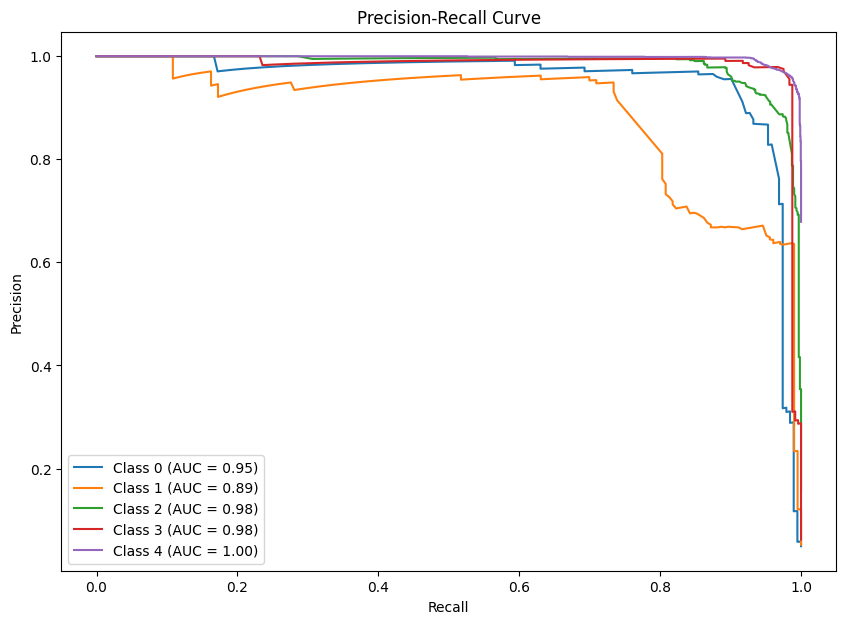

In [ ]:
print("\n--- KẾT QUẢ ĐÁNH GIÁ CUỐI CÙNG ---")
results = evaluate_full_metrics(
    model=final_model,
    dataloader=test_loader, # Sử dụng test_loader để có kết quả khách quan
    device=device,
    num_classes=len(label2id)
)

In [ ]:
vihealth_rbert = comparison_metrics(
    model=final_model,
    dataloader=test_loader, # Sử dụng test_loader để có kết quả khách quan
    device=device,
    num_classes=len(label2id)
)

# Thực thi hàm với model hiện tại của bạn
# Giả sử model của bạn tên là 'model', đã có 'test_dataloader', 'device', 'num_classes'
res, labels, probs = comparison_metrics(
    model=final_model,
    dataloader=test_loader, # Sử dụng test_loader để có kết quả khách quan
    device=device,
    num_classes=len(label2id), model_name="vihealth_rbert"
)

# --- IN KẾT QUẢ ---
print("\n" + "="*40)
print(f"   DETAILED METRICS: {res['Model']}   ")
print("="*40)

# Cách in 1: In thủ công từng dòng cho dễ nhìn
for key, value in res.items():
    if key != "Model":
        print(f"{key:<18}: {value:.4f}")

# Cách in 2: In dưới dạng bảng bằng Pandas (đẹp hơn)
import pandas as pd
df_single = pd.DataFrame([res])
print("\n--- Summary Table ---")
print(df_single.to_string(index=False))

Evaluating Model:   0%|          | 0/244 [00:00<?, ?it/s]

Evaluating vihealth_rbert:   0%|          | 0/244 [00:00<?, ?it/s]


   DETAILED METRICS: vihealth_rbert   
Accuracy          : 0.9585
Macro-Precision   : 0.9533
Macro-Recall      : 0.9081
Macro-F1          : 0.9277
Micro-F1          : 0.9585
AUC-PRC           : 0.9615
P@100             : 1.0000

--- Summary Table ---
         Model  Accuracy  Macro-Precision  Macro-Recall  Macro-F1  Micro-F1  AUC-PRC  P@100
vihealth_rbert  0.958451         0.953264      0.908052  0.927703  0.958451 0.961544    1.0
